## アメリカの食品産業労働者数のデータから異常検知

### ■方針
### ・月単位のデータであることから、異常は累積ではなく点で判断する。
### ■流れ
### ・自己相関から、周期性（季節成分）を確認
### ・ADF検定から、トレンドは２次和分過程であることを確認
### ・SARIMA(4,1,2)(0,2,1,12)を選択。※有意な自己相関が残るモデルとなった。
### ・SARIMAモデルと原系列との差分の２乗を異常値とした。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import changefinder
import seaborn as sns

import japanize_matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
raw_d = pd.read_csv("/Users/ShuntaroMiwa/00_python/lecture/06_time_series/himeno/data/worker.csv", header=None)

In [5]:
raw_d.describe()

,0
count,156.000000
mean,1737.480769
std,81.242566
min,1571.000000
25%,1678.250000
50%,1723.500000
75%,1792.000000
max,1936.000000


In [6]:
raw_d.isnull().sum()

0    0
dtype: int64

### 日付indexを付与

In [7]:
dateindex = pd.date_range(start='1967-1', end='1980-1', freq='M') 

In [8]:
raw_d.index = dateindex

In [9]:
df= raw_d.set_axis(['worker'], axis=1)

In [10]:
dat_y=df.resample('Y').sum()
dat_y.head()

,worker
1967-12-31,21436
1968-12-31,21379
1969-12-31,21490
1970-12-31,21436
1971-12-31,21188


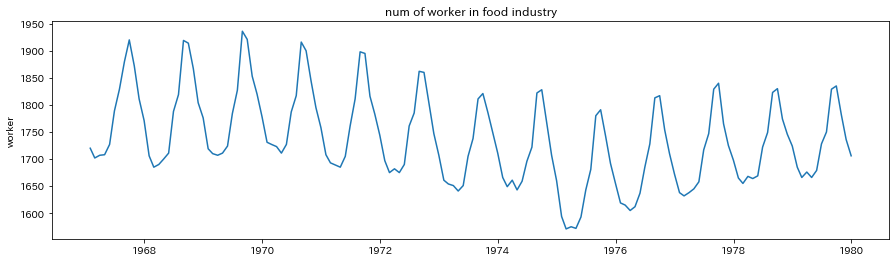

In [11]:
target = df['worker']

fig = plt.figure(figsize=(15,4))
sns.lineplot(x=df.index,y=target).set_title('num of worker in food industry')
plt.show()

### 自己相関　→12月の周期成分を確認

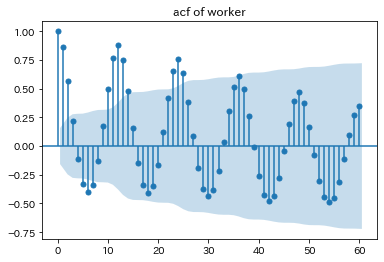

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

target = df['worker']
plot_acf(target, lags=60, title="acf of worker")
plt.show()

### 偏自己相関　→２ヶ月後や13ヶ月後に負の偏自己相関。

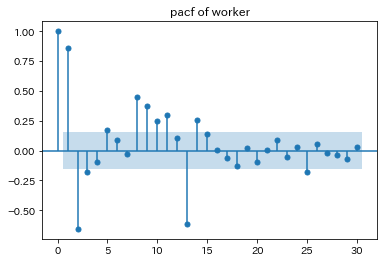

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
#https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

plot_pacf(target, lags=30, title= "pacf of worker",method='ywm')#変更：yule walker without bias correction
plt.show()

In [14]:
from statsmodels.tsa import stattools

target = df['worker']

adf = stattools.adfuller(target, regression='ctt')
print("<<workerのADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<workerのADF検定>>
t値 : -3.02, p値 : 28.8%
データ数 : 142, 使用されたラグ数 : 13
検定統計量における棄却値 : 1%=-4.45, 5%=-3.87, 10%=-3.58


### ADF検定では帰無仮設が棄却されず、単位根であることが確認された。

### 差分

In [15]:
df_diff = df.diff().dropna()
df_diff = pd.DataFrame(df_diff)
df_diff.head()

,worker
1967-02-28,-18.0
1967-03-31,5.0
1967-04-30,1.0
1967-05-31,19.0
1967-06-30,62.0


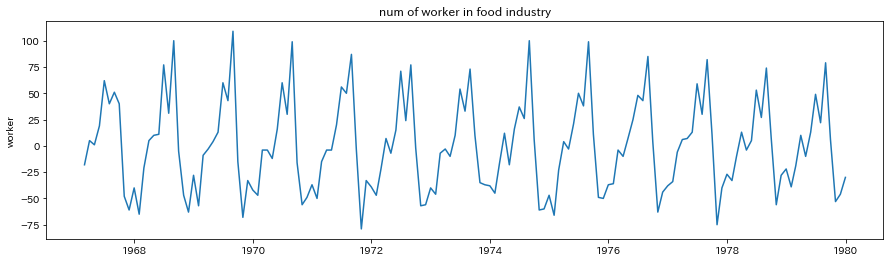

In [16]:
target = df_diff['worker']

fig = plt.figure(figsize=(15,4))
sns.lineplot(x=target.index,y=target).set_title('num of worker in food industry')
plt.show()

In [17]:
target = df_diff['worker']
adf = stattools.adfuller(target, regression='ctt')
print("<<workerのADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<workerのADF検定>>
t値 : -2.90, p値 : 34.5%
データ数 : 143, 使用されたラグ数 : 11
検定統計量における棄却値 : 1%=-4.45, 5%=-3.87, 10%=-3.58


In [18]:
##2回目
df_diff2 = df_diff.diff().dropna()
df_diff2 = pd.DataFrame(df_diff2)
df_diff2.head()

,worker
1967-03-31,23.0
1967-04-30,-4.0
1967-05-31,18.0
1967-06-30,43.0
1967-07-31,-22.0


In [19]:
target = df_diff2['worker']
adf = stattools.adfuller(target, regression='ctt')
print("<<workerのADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<workerのADF検定>>
t値 : -12.48, p値 : 0.0%
データ数 : 142, 使用されたラグ数 : 11
検定統計量における棄却値 : 1%=-4.45, 5%=-3.87, 10%=-3.58


### ADF検定から、差分を２回取ると定常過程になることを確認。→ARIMAの"I"は2になる（はず）

### 対数差分

In [20]:
target = df['worker']
target_lg = np.log(target) - np.log(target.shift(1))#対数の差
target_lg.dropna(inplace=True)
target_lg *= 100
target_lg = pd.DataFrame(target_lg)

target_lg.head()

,worker
1967-02-28,-1.052026
1967-03-31,0.293341
1967-04-30,0.058565
1967-05-31,1.106270
1967-06-30,3.527101


In [21]:
target = target_lg['worker']
adf = stattools.adfuller(target, regression='ctt')
print("<<workerのADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<workerのADF検定>>
t値 : -2.76, p値 : 42.2%
データ数 : 143, 使用されたラグ数 : 11
検定統計量における棄却値 : 1%=-4.45, 5%=-3.87, 10%=-3.58


### 対数差分（2回目）

In [22]:
target = target_lg['worker']
df_lg2 = np.log(target) - np.log(target.shift(1))#対数の差
df_lg2.dropna(inplace=True)
df_lg2 *= 100
df_lg2 = pd.DataFrame(target_lg)

df_lg2.head()

,worker
1967-02-28,-1.052026
1967-03-31,0.293341
1967-04-30,0.058565
1967-05-31,1.106270
1967-06-30,3.527101


In [23]:
target = df_lg2['worker']

adf = stattools.adfuller(target, regression='ctt')
print("<<workerのADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<workerのADF検定>>
t値 : -2.76, p値 : 42.2%
データ数 : 143, 使用されたラグ数 : 11
検定統計量における棄却値 : 1%=-4.45, 5%=-3.87, 10%=-3.58


### 対数差分は２回取っても定常過程にならないことを確認。
### ２階差分のデータについてdecompose

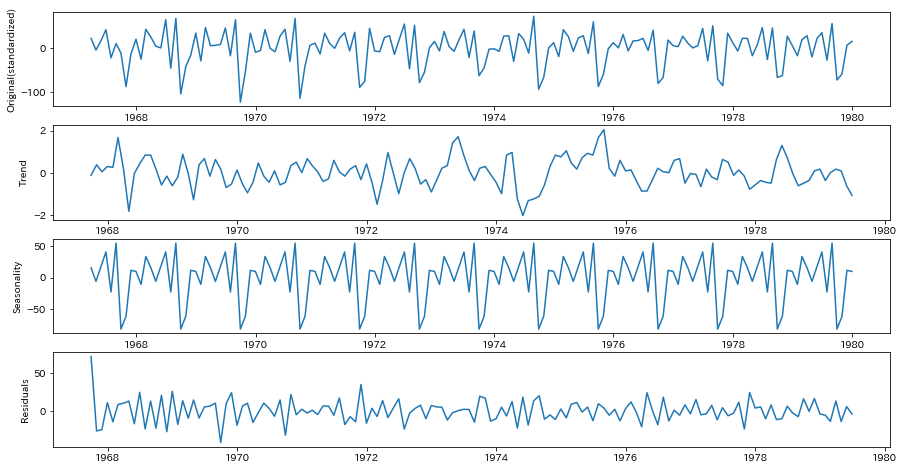

In [24]:
import statsmodels.api as sm
from statsmodels.tsa import stattools
# statsmodel のseasonal_decomposeで俯瞰データ出力　　　オリジナル、トレンド、季節性、残差

target =df_diff2['worker']
res = sm.tsa.seasonal_decompose(target, freq=12)

# res = sm.tsa.seasonal_decompose(passengers) # 解析結果は取得済み

original = target # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(15, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(target)
plt.ylabel("Original(standardized)")

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.show()

### 階差を２回取っても周期性は残っていることを確認。
## モデル選択
### 1967年1月〜1971年12月のデータ（2回差分）を訓練データとし、ARMAの次数を検討

In [25]:
import datetime as dt
df_train = df_diff2[(df_diff2.index >= dt.datetime(1967,1,31)) & (df_diff2.index < dt.datetime(1972,1,1))]

In [26]:
df_train.shape

(58, 1)

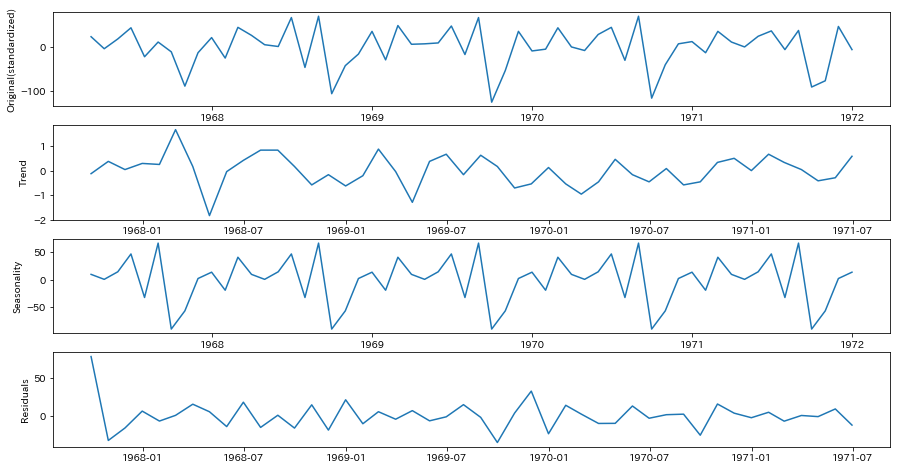

In [27]:
target = df_train['worker']
res2 = sm.tsa.seasonal_decompose(target, freq=12)

# res = sm.tsa.seasonal_decompose(passengers) # 解析結果は取得済み

original = target # オリジナルデータ
trend = res2.trend # トレンドデータ
seasonal = res2.seasonal # 季節性データ
residual = res2.resid # 残差データ

plt.figure(figsize=(15, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(target)
plt.ylabel("Original(standardized)")

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.show()

In [28]:
from statsmodels.tsa.api import AR, ARMA, ARIMA, SARIMAX

In [29]:
resDiff = sm.tsa.arma_order_select_ic(df_train, ic='aic', trend='nc')
resDiff

{'aic':             0           1           2
 0         NaN  607.618930  609.614798
 1  607.645472  599.417037  601.345434
 2  609.630689  601.287035  601.147376
 3  611.627970  599.764577  602.191641
 4  612.213081  595.179110  577.557605,
 'aic_min_order': (4, 2)}

### AIC基準を元に、ARMA = (4,2) を選択。

### 差分を取っていない原系列の訓練データをもとに、SARIMAモデルの次数を検討する。

In [34]:
train = df[(df.index >= dt.datetime(1967,1,31)) & (df.index < dt.datetime(1972,1,1))]

In [35]:
SARIMA_4_0_2_111 = sm.tsa.SARIMAX(train, order=(4,0,2), seasonal_order=(1,1,1,12)).fit(method='bfgs', maxiter=300)
print(SARIMA_4_0_2_111.summary())

         Current function value: 3.171741
         Iterations: 3
         Function evaluations: 47
         Gradient evaluations: 36
                                      SARIMAX Results                                       
Dep. Variable:                               worker   No. Observations:                   60
Model:             SARIMAX(4, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -190.304
Date:                              Tue, 08 Feb 2022   AIC                            398.609
Time:                                      11:07:34   BIC                            415.450
Sample:                                  01-31-1967   HQIC                           404.973
                                       - 12-31-1971                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

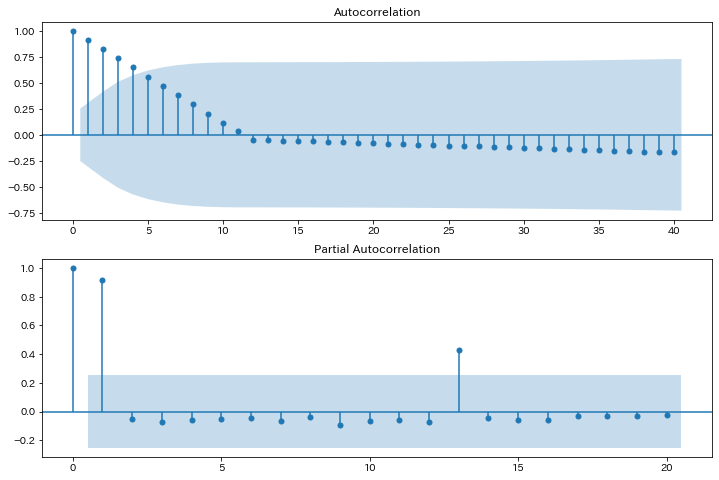

In [36]:
# 残差のチェック
residSARIMA = SARIMA_4_0_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=20, ax=ax2,method='ywm')

In [37]:
SARIMA_4_1_2_111 = sm.tsa.SARIMAX(train, order=(4,1,2), seasonal_order=(1,1,1,12)).fit(method='bfgs', maxiter=300)
print(SARIMA_4_1_2_111.summary())

         Current function value: 3.076920
         Iterations: 11
         Function evaluations: 53
         Gradient evaluations: 42
                                      SARIMAX Results                                       
Dep. Variable:                               worker   No. Observations:                   60
Model:             SARIMAX(4, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -184.615
Date:                              Tue, 08 Feb 2022   AIC                            387.230
Time:                                      11:08:37   BIC                            403.882
Sample:                                  01-31-1967   HQIC                           393.496
                                       - 12-31-1971                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

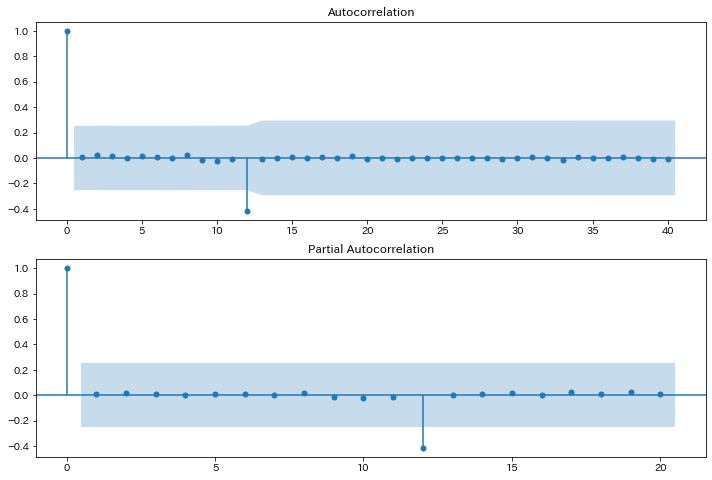

In [38]:
# 残差のチェック
residSARIMA = SARIMA_4_1_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=20, ax=ax2,method='ywm')

In [39]:
SARIMA_4_2_2_111 = sm.tsa.SARIMAX(train, order=(4,2,2), seasonal_order=(1,1,1,12)).fit(method='bfgs', maxiter=300)
print(SARIMA_4_2_2_111.summary())

         Current function value: 3.431270
         Iterations: 2
         Function evaluations: 62
         Gradient evaluations: 50
                                      SARIMAX Results                                       
Dep. Variable:                               worker   No. Observations:                   60
Model:             SARIMAX(4, 2, 2)x(1, 1, [1], 12)   Log Likelihood                -205.876
Date:                              Tue, 08 Feb 2022   AIC                            429.752
Time:                                      11:10:13   BIC                            446.210
Sample:                                  01-31-1967   HQIC                           435.918
                                       - 12-31-1971                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

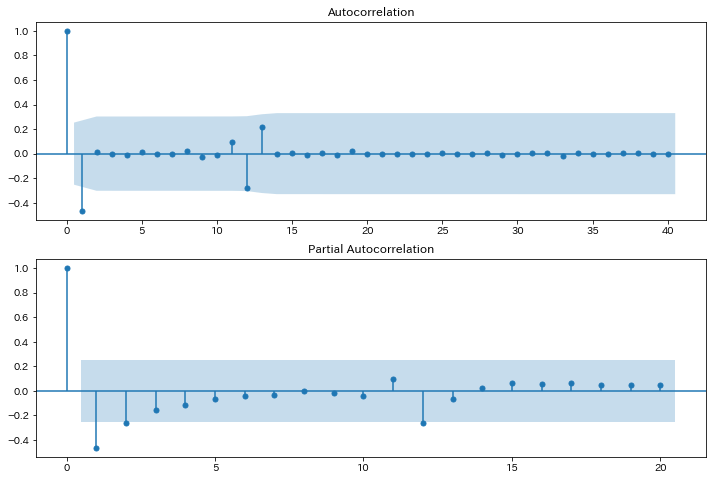

In [36]:
# 残差のチェック
residSARIMA = SARIMA_4_2_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=20, ax=ax2,method='ywm')

-  定常時系列の解析に使われるARMAモデル・SARIMAモデルとは？
-  https://ai-trend.jp/basic-study/time-series-analysis/sarima_model/

### 周期性成分の次数についてグリッドサーチ

In [100]:
import itertools
 
# 各パラメータの範囲を決める
p = d = q = range(0, 5)
sp = sd = sq = range(0, 3)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = list(itertools.product(p, d, q))
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]
pdq[0:6]


[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0)]

In [262]:
import warnings
 
warnings.filterwarnings("ignore") # warnings を表示させないようにする
 
 
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                          order = param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=True,
                          enforce_invertibility=True)
 
            results = mod.fit()
             
            print('order{}, s_order{} - AIC: {}'.format(param, param_seasonal, results.aic))
 
#             if results.aic &lt; best_result[2]:
#                 best_result = [param, param_seasonal, results.aic]
        except:
            continue
             
print('\AICが最も良いモデル:', best_result)

order(0, 0, 0), s_order(0, 0, 0, 12) - AIC: 1070.649373203236
order(0, 0, 0), s_order(0, 0, 1, 12) - AIC: 1021.8372029446209
order(0, 0, 0), s_order(0, 0, 2, 12) - AIC: 990.4868293715303
order(0, 0, 0), s_order(0, 1, 0, 12) - AIC: 410.77756521504597
order(0, 0, 0), s_order(0, 1, 1, 12) - AIC: 411.62633811499023
order(0, 0, 0), s_order(0, 1, 2, 12) - AIC: 407.29698459859975
order(0, 0, 0), s_order(0, 2, 0, 12) - AIC: 333.04069630579033
order(0, 0, 0), s_order(0, 2, 1, 12) - AIC: 331.77969486527184
order(0, 0, 0), s_order(0, 2, 2, 12) - AIC: 330.2933939243407
order(0, 0, 0), s_order(1, 0, 0, 12) - AIC: 627.3065696059276
order(0, 0, 0), s_order(1, 0, 1, 12) - AIC: 635.0998590994981
order(0, 0, 0), s_order(1, 0, 2, 12) - AIC: 624.8774585693917
order(0, 0, 0), s_order(1, 1, 0, 12) - AIC: 412.4562651006491
order(0, 0, 0), s_order(1, 1, 1, 12) - AIC: 412.2670838531883
order(0, 0, 0), s_order(1, 1, 2, 12) - AIC: 408.7167826293635
order(0, 0, 0), s_order(1, 2, 0, 12) - AIC: 334.18573054712823
o

order(0, 0, 4), s_order(2, 2, 2, 12) - AIC: 317.81937707132926
order(0, 1, 0), s_order(0, 0, 0, 12) - AIC: 621.1236246190844
order(0, 1, 0), s_order(0, 0, 1, 12) - AIC: 579.7465260502213
order(0, 1, 0), s_order(0, 0, 2, 12) - AIC: 554.2620292060647
order(0, 1, 0), s_order(0, 1, 0, 12) - AIC: 388.7532716075634
order(0, 1, 0), s_order(0, 1, 1, 12) - AIC: 388.92246269702014
order(0, 1, 0), s_order(0, 1, 2, 12) - AIC: 390.8459408481669
order(0, 1, 0), s_order(0, 2, 0, 12) - AIC: 317.4477719343072
order(0, 1, 0), s_order(0, 2, 1, 12) - AIC: 312.91811005482396
order(0, 1, 0), s_order(0, 2, 2, 12) - AIC: 311.70047815730254
order(0, 1, 0), s_order(1, 0, 0, 12) - AIC: 514.8848704801115
order(0, 1, 0), s_order(1, 0, 1, 12) - AIC: 515.7064288289307
order(0, 1, 0), s_order(1, 0, 2, 12) - AIC: 517.7021173499008
order(0, 1, 0), s_order(1, 1, 0, 12) - AIC: 389.0037106130186
order(0, 1, 0), s_order(1, 1, 1, 12) - AIC: 390.01897170635465
order(0, 1, 0), s_order(1, 1, 2, 12) - AIC: 392.3259391033032
ord

order(0, 1, 4), s_order(2, 1, 2, 12) - AIC: 385.24866312458056
order(0, 1, 4), s_order(2, 2, 0, 12) - AIC: 307.6128007661007
order(0, 1, 4), s_order(2, 2, 1, 12) - AIC: 309.57321360982434
order(0, 1, 4), s_order(2, 2, 2, 12) - AIC: 311.6140851188514
order(0, 2, 0), s_order(0, 0, 0, 12) - AIC: 607.6374129820238
order(0, 2, 0), s_order(0, 0, 1, 12) - AIC: 579.5086030807573
order(0, 2, 0), s_order(0, 0, 2, 12) - AIC: 559.2337620505233
order(0, 2, 0), s_order(0, 1, 0, 12) - AIC: 432.70397210094944
order(0, 2, 0), s_order(0, 1, 1, 12) - AIC: 431.28139035082614
order(0, 2, 0), s_order(0, 1, 2, 12) - AIC: 433.21498240771257
order(0, 2, 0), s_order(0, 2, 0, 12) - AIC: 348.872284300641
order(0, 2, 0), s_order(0, 2, 1, 12) - AIC: 344.15950246444993
order(0, 2, 0), s_order(0, 2, 2, 12) - AIC: 339.7099778451285
order(0, 2, 0), s_order(1, 0, 0, 12) - AIC: 552.9389280465319
order(0, 2, 0), s_order(1, 0, 1, 12) - AIC: 611.6378591268256
order(0, 2, 0), s_order(1, 0, 2, 12) - AIC: 551.7157854880901
ord

order(0, 2, 4), s_order(2, 0, 2, 12) - AIC: 513.63337539131
order(0, 2, 4), s_order(2, 1, 0, 12) - AIC: 381.20594733452685
order(0, 2, 4), s_order(2, 1, 1, 12) - AIC: 383.1544201124965
order(0, 2, 4), s_order(2, 1, 2, 12) - AIC: 385.15259633623765
order(0, 2, 4), s_order(2, 2, 0, 12) - AIC: 305.51568721312555
order(0, 2, 4), s_order(2, 2, 1, 12) - AIC: 307.48581148608804
order(0, 2, 4), s_order(2, 2, 2, 12) - AIC: 309.48717440542015
order(0, 3, 0), s_order(0, 0, 0, 12) - AIC: 647.2472060281967
order(0, 3, 0), s_order(0, 0, 1, 12) - AIC: 625.3282668040298
order(0, 3, 0), s_order(0, 0, 2, 12) - AIC: 606.0626790817788
order(0, 3, 0), s_order(0, 1, 0, 12) - AIC: 480.124624393656
order(0, 3, 0), s_order(0, 1, 1, 12) - AIC: 477.09751584731487
order(0, 3, 0), s_order(0, 1, 2, 12) - AIC: 478.9399704388225
order(0, 3, 0), s_order(0, 2, 0, 12) - AIC: 381.15404066935304
order(0, 3, 0), s_order(0, 2, 1, 12) - AIC: 376.8397020871566
order(0, 3, 0), s_order(0, 2, 2, 12) - AIC: 371.29572057001343
ord

order(0, 3, 4), s_order(2, 0, 1, 12) - AIC: 544.4386109579133
order(0, 3, 4), s_order(2, 0, 2, 12) - AIC: 519.4024295056752
order(0, 3, 4), s_order(2, 1, 0, 12) - AIC: 384.8243666284077
order(0, 3, 4), s_order(2, 1, 1, 12) - AIC: 387.23664143142844
order(0, 3, 4), s_order(2, 1, 2, 12) - AIC: 388.80864038354315
order(0, 3, 4), s_order(2, 2, 0, 12) - AIC: 305.9579406661186
order(0, 3, 4), s_order(2, 2, 1, 12) - AIC: 307.94766002870443
order(0, 3, 4), s_order(2, 2, 2, 12) - AIC: 309.9314930657129
order(0, 4, 0), s_order(0, 0, 0, 12) - AIC: 701.2537438624647
order(0, 4, 0), s_order(0, 0, 1, 12) - AIC: 681.3756731616504
order(0, 4, 0), s_order(0, 0, 2, 12) - AIC: 662.8628785736537
order(0, 4, 0), s_order(0, 1, 0, 12) - AIC: 526.6922601626937
order(0, 4, 0), s_order(0, 1, 1, 12) - AIC: 521.7383773164154
order(0, 4, 0), s_order(0, 1, 2, 12) - AIC: 523.497551031137
order(0, 4, 0), s_order(0, 2, 0, 12) - AIC: 411.6893397676569
order(0, 4, 0), s_order(0, 2, 1, 12) - AIC: 407.73067323464034
order

order(0, 4, 4), s_order(1, 2, 1, 12) - AIC: 312.40621349822567
order(0, 4, 4), s_order(1, 2, 2, 12) - AIC: 312.1689830088774
order(0, 4, 4), s_order(2, 0, 1, 12) - AIC: 535.0582732902269
order(0, 4, 4), s_order(2, 0, 2, 12) - AIC: 84.62199904754083
order(0, 4, 4), s_order(2, 1, 0, 12) - AIC: 389.78670483790586
order(0, 4, 4), s_order(2, 1, 1, 12) - AIC: 391.6060086574222
order(0, 4, 4), s_order(2, 1, 2, 12) - AIC: 393.619848099644
order(0, 4, 4), s_order(2, 2, 0, 12) - AIC: 310.2149961385179
order(0, 4, 4), s_order(2, 2, 1, 12) - AIC: 312.1514115283311
order(0, 4, 4), s_order(2, 2, 2, 12) - AIC: 314.37974804396754
order(1, 0, 0), s_order(0, 0, 0, 12) - AIC: 640.8658652587436
order(1, 0, 0), s_order(0, 0, 1, 12) - AIC: 599.3947290302875
order(1, 0, 0), s_order(0, 0, 2, 12) - AIC: 573.8540776949799
order(1, 0, 0), s_order(0, 1, 0, 12) - AIC: 389.33871995411357
order(1, 0, 0), s_order(0, 1, 1, 12) - AIC: 389.7316468833242
order(1, 0, 0), s_order(0, 1, 2, 12) - AIC: 391.33656658893904
orde

order(1, 0, 4), s_order(1, 1, 2, 12) - AIC: 391.4635751986623
order(1, 0, 4), s_order(1, 2, 0, 12) - AIC: 317.3028004215884
order(1, 0, 4), s_order(1, 2, 1, 12) - AIC: 317.12487904116284
order(1, 0, 4), s_order(1, 2, 2, 12) - AIC: 318.1473337869427
order(1, 0, 4), s_order(2, 0, 0, 12) - AIC: 532.4011500391006
order(1, 0, 4), s_order(2, 0, 1, 12) - AIC: 535.7833718780882
order(1, 0, 4), s_order(2, 0, 2, 12) - AIC: 535.6385261258785
order(1, 0, 4), s_order(2, 1, 0, 12) - AIC: 389.67205890985235
order(1, 0, 4), s_order(2, 1, 1, 12) - AIC: 391.12651730320675
order(1, 0, 4), s_order(2, 1, 2, 12) - AIC: 393.129419982948
order(1, 0, 4), s_order(2, 2, 0, 12) - AIC: 314.9376785233089
order(1, 0, 4), s_order(2, 2, 1, 12) - AIC: 316.71624336500736
order(1, 0, 4), s_order(2, 2, 2, 12) - AIC: 318.51727754308786
order(1, 1, 0), s_order(0, 0, 0, 12) - AIC: 604.0540309068442
order(1, 1, 0), s_order(0, 0, 1, 12) - AIC: 571.0636845507528
order(1, 1, 0), s_order(0, 0, 2, 12) - AIC: 548.7665281648071
orde

order(1, 1, 4), s_order(1, 0, 2, 12) - AIC: 512.4164355048349
order(1, 1, 4), s_order(1, 1, 0, 12) - AIC: 382.34296487728864
order(1, 1, 4), s_order(1, 1, 1, 12) - AIC: 384.00459899429524
order(1, 1, 4), s_order(1, 1, 2, 12) - AIC: 383.9292018583245
order(1, 1, 4), s_order(1, 2, 0, 12) - AIC: 307.8194749209876
order(1, 1, 4), s_order(1, 2, 1, 12) - AIC: 308.3301895982129
order(1, 1, 4), s_order(1, 2, 2, 12) - AIC: 309.8107961181916
order(1, 1, 4), s_order(2, 0, 0, 12) - AIC: 510.60841238044696
order(1, 1, 4), s_order(2, 0, 1, 12) - AIC: 512.4976610754181
order(1, 1, 4), s_order(2, 0, 2, 12) - AIC: 514.354739706997
order(1, 1, 4), s_order(2, 1, 0, 12) - AIC: 381.9163757236593
order(1, 1, 4), s_order(2, 1, 1, 12) - AIC: 383.8346887455228
order(1, 1, 4), s_order(2, 1, 2, 12) - AIC: 385.6804468353193
order(1, 1, 4), s_order(2, 2, 0, 12) - AIC: 307.71138242924724
order(1, 1, 4), s_order(2, 2, 1, 12) - AIC: 309.38109689939347
order(1, 1, 4), s_order(2, 2, 2, 12) - AIC: 311.17400312046686
ord

order(1, 2, 4), s_order(1, 0, 0, 12) - AIC: 509.14020519787755
order(1, 2, 4), s_order(1, 0, 1, 12) - AIC: 510.9886144387059
order(1, 2, 4), s_order(1, 0, 2, 12) - AIC: 512.9024160117003
order(1, 2, 4), s_order(1, 1, 0, 12) - AIC: 381.51064081264093
order(1, 2, 4), s_order(1, 1, 1, 12) - AIC: 382.7454119842849
order(1, 2, 4), s_order(1, 1, 2, 12) - AIC: 383.696150191454
order(1, 2, 4), s_order(1, 2, 0, 12) - AIC: 305.41406220586333
order(1, 2, 4), s_order(1, 2, 1, 12) - AIC: 306.4349558270115
order(1, 2, 4), s_order(1, 2, 2, 12) - AIC: 308.383515609595
order(1, 2, 4), s_order(2, 0, 0, 12) - AIC: 510.98109110374355
order(1, 2, 4), s_order(2, 0, 1, 12) - AIC: 512.9946940357274
order(1, 2, 4), s_order(2, 0, 2, 12) - AIC: 514.8582445066755
order(1, 2, 4), s_order(2, 1, 0, 12) - AIC: 381.9787598148237
order(1, 2, 4), s_order(2, 1, 1, 12) - AIC: 383.55144438084517
order(1, 2, 4), s_order(2, 1, 2, 12) - AIC: 385.5510459042673
order(1, 2, 4), s_order(2, 2, 0, 12) - AIC: 305.97303011269963
orde

order(1, 3, 4), s_order(0, 2, 0, 12) - AIC: 306.4790491424096
order(1, 3, 4), s_order(0, 2, 1, 12) - AIC: 304.35204636780094
order(1, 3, 4), s_order(0, 2, 2, 12) - AIC: 305.92345164387825
order(1, 3, 4), s_order(1, 0, 0, 12) - AIC: 512.6713643397311
order(1, 3, 4), s_order(1, 0, 1, 12) - AIC: 514.2842746473714
order(1, 3, 4), s_order(1, 0, 2, 12) - AIC: 517.5987033199069
order(1, 3, 4), s_order(1, 1, 0, 12) - AIC: 384.6584556003271
order(1, 3, 4), s_order(1, 1, 1, 12) - AIC: 386.2759122804055
order(1, 3, 4), s_order(1, 1, 2, 12) - AIC: 388.2230573183079
order(1, 3, 4), s_order(1, 2, 0, 12) - AIC: 306.0764838981594
order(1, 3, 4), s_order(1, 2, 1, 12) - AIC: 306.01607743461875
order(1, 3, 4), s_order(1, 2, 2, 12) - AIC: 307.6682496534092
order(1, 3, 4), s_order(2, 0, 0, 12) - AIC: 514.3136873519793
order(1, 3, 4), s_order(2, 0, 1, 12) - AIC: 516.186627465903
order(1, 3, 4), s_order(2, 0, 2, 12) - AIC: 519.5363514509074
order(1, 3, 4), s_order(2, 1, 0, 12) - AIC: 386.3180467734851
order(

order(1, 4, 4), s_order(0, 1, 2, 12) - AIC: 400.39013442387295
order(1, 4, 4), s_order(0, 2, 0, 12) - AIC: 314.43921829036884
order(1, 4, 4), s_order(0, 2, 1, 12) - AIC: 318.21884722049117
order(1, 4, 4), s_order(0, 2, 2, 12) - AIC: 309.65997695936665
order(1, 4, 4), s_order(1, 0, 0, 12) - AIC: 523.6514464702918
order(1, 4, 4), s_order(1, 0, 1, 12) - AIC: 525.6872024307859
order(1, 4, 4), s_order(1, 0, 2, 12) - AIC: 528.1413040667762
order(1, 4, 4), s_order(1, 1, 0, 12) - AIC: 398.3218477361033
order(1, 4, 4), s_order(1, 1, 1, 12) - AIC: 400.3031651012482
order(1, 4, 4), s_order(1, 1, 2, 12) - AIC: 402.11507769367813
order(1, 4, 4), s_order(1, 2, 0, 12) - AIC: 309.30544282931305
order(1, 4, 4), s_order(1, 2, 1, 12) - AIC: 316.84924054610593
order(1, 4, 4), s_order(1, 2, 2, 12) - AIC: 315.0069846168174
order(1, 4, 4), s_order(2, 0, 0, 12) - AIC: 525.6572555914609
order(1, 4, 4), s_order(2, 0, 1, 12) - AIC: 526.79269329302
order(1, 4, 4), s_order(2, 0, 2, 12) - AIC: 529.4660859788415
ord

order(2, 0, 4), s_order(0, 2, 1, 12) - AIC: 315.6585921946346
order(2, 0, 4), s_order(0, 2, 2, 12) - AIC: 316.35123716331543
order(2, 0, 4), s_order(1, 0, 0, 12) - AIC: 531.9958777676035
order(2, 0, 4), s_order(1, 0, 1, 12) - AIC: 533.2726278678341
order(2, 0, 4), s_order(1, 0, 2, 12) - AIC: 534.6696423135807
order(2, 0, 4), s_order(1, 1, 0, 12) - AIC: 390.8086221905676
order(2, 0, 4), s_order(1, 1, 1, 12) - AIC: 392.22103453524807
order(2, 0, 4), s_order(1, 1, 2, 12) - AIC: 392.0665511997331
order(2, 0, 4), s_order(1, 2, 0, 12) - AIC: 316.6429845559636
order(2, 0, 4), s_order(1, 2, 1, 12) - AIC: 316.90056145935
order(2, 0, 4), s_order(1, 2, 2, 12) - AIC: 317.7418671182607
order(2, 0, 4), s_order(2, 0, 0, 12) - AIC: 535.7142818105636
order(2, 0, 4), s_order(2, 0, 1, 12) - AIC: 538.386548103823
order(2, 0, 4), s_order(2, 0, 2, 12) - AIC: 538.7340129202005
order(2, 0, 4), s_order(2, 1, 0, 12) - AIC: 390.1976854338698
order(2, 0, 4), s_order(2, 1, 1, 12) - AIC: 391.79520834419424
order(2,

order(2, 1, 4), s_order(0, 2, 0, 12) - AIC: 308.45977305745834
order(2, 1, 4), s_order(0, 2, 1, 12) - AIC: 306.9132499187524
order(2, 1, 4), s_order(0, 2, 2, 12) - AIC: 308.0373523331661
order(2, 1, 4), s_order(1, 0, 0, 12) - AIC: 510.5317527592316
order(2, 1, 4), s_order(1, 0, 1, 12) - AIC: 509.33793814585226
order(2, 1, 4), s_order(1, 0, 2, 12) - AIC: 516.5081119208294
order(2, 1, 4), s_order(1, 1, 0, 12) - AIC: 382.9576184024172
order(2, 1, 4), s_order(1, 1, 1, 12) - AIC: 384.8696497930605
order(2, 1, 4), s_order(1, 1, 2, 12) - AIC: 385.34347527927525
order(2, 1, 4), s_order(1, 2, 0, 12) - AIC: 308.0637392306917
order(2, 1, 4), s_order(1, 2, 1, 12) - AIC: 308.33169695381724
order(2, 1, 4), s_order(1, 2, 2, 12) - AIC: 309.5790113157246
order(2, 1, 4), s_order(2, 0, 0, 12) - AIC: 512.4718466064047
order(2, 1, 4), s_order(2, 0, 1, 12) - AIC: 514.4845197971745
order(2, 1, 4), s_order(2, 0, 2, 12) - AIC: 520.9321429147997
order(2, 1, 4), s_order(2, 1, 0, 12) - AIC: 383.18560726147405
ord

order(2, 2, 4), s_order(0, 2, 0, 12) - AIC: 302.1599301094818
order(2, 2, 4), s_order(0, 2, 1, 12) - AIC: 303.8559138089138
order(2, 2, 4), s_order(0, 2, 2, 12) - AIC: 305.27610926875985
order(2, 2, 4), s_order(1, 0, 0, 12) - AIC: 515.4063704675987
order(2, 2, 4), s_order(1, 0, 1, 12) - AIC: 505.7891579430418
order(2, 2, 4), s_order(1, 0, 2, 12) - AIC: 535.0769632053863
order(2, 2, 4), s_order(1, 1, 0, 12) - AIC: 381.6611652724044
order(2, 2, 4), s_order(1, 1, 1, 12) - AIC: 383.0979414548764
order(2, 2, 4), s_order(1, 1, 2, 12) - AIC: 377.3381070113902
order(2, 2, 4), s_order(1, 2, 0, 12) - AIC: 304.7078529145523
order(2, 2, 4), s_order(1, 2, 1, 12) - AIC: 305.4107876570672
order(2, 2, 4), s_order(1, 2, 2, 12) - AIC: 307.15967785572593
order(2, 2, 4), s_order(2, 0, 0, 12) - AIC: 511.88381177472564
order(2, 2, 4), s_order(2, 0, 1, 12) - AIC: 506.91975831158436
order(2, 2, 4), s_order(2, 0, 2, 12) - AIC: 506.3348161558251
order(2, 2, 4), s_order(2, 1, 0, 12) - AIC: 376.72710325647796
ord

order(2, 3, 4), s_order(0, 1, 0, 12) - AIC: 384.4763730370816
order(2, 3, 4), s_order(0, 1, 1, 12) - AIC: 386.4068545504989
order(2, 3, 4), s_order(0, 1, 2, 12) - AIC: 388.00237905627694
order(2, 3, 4), s_order(0, 2, 0, 12) - AIC: 303.2967491372597
order(2, 3, 4), s_order(0, 2, 1, 12) - AIC: 303.5234213404692
order(2, 3, 4), s_order(0, 2, 2, 12) - AIC: 303.3549265121607
order(2, 3, 4), s_order(1, 0, 0, 12) - AIC: 506.32535261964205
order(2, 3, 4), s_order(1, 0, 1, 12) - AIC: 507.45748952086456
order(2, 3, 4), s_order(1, 0, 2, 12) - AIC: 526.4360680007858
order(2, 3, 4), s_order(1, 1, 0, 12) - AIC: 386.4270082607393
order(2, 3, 4), s_order(1, 1, 1, 12) - AIC: 388.40201487259617
order(2, 3, 4), s_order(1, 1, 2, 12) - AIC: 390.018461326616
order(2, 3, 4), s_order(1, 2, 0, 12) - AIC: 304.106495244393
order(2, 3, 4), s_order(1, 2, 1, 12) - AIC: 304.58534136552714
order(2, 3, 4), s_order(1, 2, 2, 12) - AIC: 304.5710568687494
order(2, 3, 4), s_order(2, 0, 0, 12) - AIC: 509.22623680974857
orde

order(2, 4, 4), s_order(0, 1, 0, 12) - AIC: 389.1465199398936
order(2, 4, 4), s_order(0, 1, 1, 12) - AIC: 391.1345097391744
order(2, 4, 4), s_order(0, 1, 2, 12) - AIC: 392.6835754367698
order(2, 4, 4), s_order(0, 2, 0, 12) - AIC: 313.06705240986565
order(2, 4, 4), s_order(0, 2, 1, 12) - AIC: 310.21539736877656
order(2, 4, 4), s_order(0, 2, 2, 12) - AIC: 311.68204691461904
order(2, 4, 4), s_order(1, 0, 0, 12) - AIC: 543.4512433212512
order(2, 4, 4), s_order(1, 0, 1, 12) - AIC: 554.2592603596049
order(2, 4, 4), s_order(1, 0, 2, 12) - AIC: 549.1442867186512
order(2, 4, 4), s_order(1, 1, 0, 12) - AIC: 391.1380358626487
order(2, 4, 4), s_order(1, 1, 1, 12) - AIC: 393.0538504211529
order(2, 4, 4), s_order(1, 1, 2, 12) - AIC: 394.4734189208116
order(2, 4, 4), s_order(1, 2, 0, 12) - AIC: 311.3582054044904
order(2, 4, 4), s_order(1, 2, 1, 12) - AIC: 311.8421889282453
order(2, 4, 4), s_order(1, 2, 2, 12) - AIC: 314.22459870162857
order(2, 4, 4), s_order(2, 0, 0, 12) - AIC: 546.5789984671123
orde

order(3, 0, 4), s_order(0, 2, 0, 12) - AIC: 317.8018084343465
order(3, 0, 4), s_order(0, 2, 1, 12) - AIC: 315.41472241326875
order(3, 0, 4), s_order(0, 2, 2, 12) - AIC: 316.56482865251894
order(3, 0, 4), s_order(1, 0, 0, 12) - AIC: 535.7784890691144
order(3, 0, 4), s_order(1, 0, 1, 12) - AIC: 536.6696641011213
order(3, 0, 4), s_order(1, 0, 2, 12) - AIC: 534.4188471180873
order(3, 0, 4), s_order(1, 1, 0, 12) - AIC: 389.1114057188598
order(3, 0, 4), s_order(1, 1, 1, 12) - AIC: 393.272697284166
order(3, 0, 4), s_order(1, 1, 2, 12) - AIC: 393.51107581811596
order(3, 0, 4), s_order(1, 2, 0, 12) - AIC: 317.09234184370774
order(3, 0, 4), s_order(1, 2, 1, 12) - AIC: 316.8809917181906
order(3, 0, 4), s_order(1, 2, 2, 12) - AIC: 317.69446872125036
order(3, 0, 4), s_order(2, 0, 0, 12) - AIC: 529.9871770573217
order(3, 0, 4), s_order(2, 0, 1, 12) - AIC: 551.4397843751287
order(3, 0, 4), s_order(2, 0, 2, 12) - AIC: 535.0821924104457
order(3, 0, 4), s_order(2, 1, 0, 12) - AIC: 391.95860495826315
ord

order(3, 1, 4), s_order(0, 1, 1, 12) - AIC: 384.82330503508894
order(3, 1, 4), s_order(0, 1, 2, 12) - AIC: 378.73113444682286
order(3, 1, 4), s_order(0, 2, 0, 12) - AIC: 310.07950791921627
order(3, 1, 4), s_order(0, 2, 1, 12) - AIC: 308.90187388876495
order(3, 1, 4), s_order(0, 2, 2, 12) - AIC: 310.4288645866057
order(3, 1, 4), s_order(1, 0, 0, 12) - AIC: 510.7019308112091
order(3, 1, 4), s_order(1, 0, 1, 12) - AIC: 512.6161482016649
order(3, 1, 4), s_order(1, 1, 0, 12) - AIC: 384.97808791995084
order(3, 1, 4), s_order(1, 1, 1, 12) - AIC: 389.1882616857785
order(3, 1, 4), s_order(1, 1, 2, 12) - AIC: 380.45637295115506
order(3, 1, 4), s_order(1, 2, 0, 12) - AIC: 310.33525739060843
order(3, 1, 4), s_order(1, 2, 1, 12) - AIC: 310.39389488509187
order(3, 1, 4), s_order(1, 2, 2, 12) - AIC: 311.6737374345974
order(3, 1, 4), s_order(2, 0, 0, 12) - AIC: 515.3431606236892
order(3, 1, 4), s_order(2, 0, 1, 12) - AIC: 517.0961561652256
order(3, 1, 4), s_order(2, 0, 2, 12) - AIC: 516.1820453659452


order(3, 2, 4), s_order(0, 1, 1, 12) - AIC: 383.619751880089
order(3, 2, 4), s_order(0, 1, 2, 12) - AIC: 376.82406801690644
order(3, 2, 4), s_order(0, 2, 0, 12) - AIC: 305.8260642598875
order(3, 2, 4), s_order(0, 2, 1, 12) - AIC: 303.9751433528346
order(3, 2, 4), s_order(0, 2, 2, 12) - AIC: 303.6707881199374
order(3, 2, 4), s_order(1, 0, 0, 12) - AIC: 502.7227370843657
order(3, 2, 4), s_order(1, 0, 1, 12) - AIC: 505.66648098297935
order(3, 2, 4), s_order(1, 0, 2, 12) - AIC: 22.0
order(3, 2, 4), s_order(1, 1, 0, 12) - AIC: 383.6241989356987
order(3, 2, 4), s_order(1, 1, 1, 12) - AIC: 381.85822478772576
order(3, 2, 4), s_order(1, 1, 2, 12) - AIC: 378.66530202723413
order(3, 2, 4), s_order(1, 2, 0, 12) - AIC: 306.0704797584877
order(3, 2, 4), s_order(1, 2, 1, 12) - AIC: 306.6662251074197
order(3, 2, 4), s_order(1, 2, 2, 12) - AIC: 308.50631213568244
order(3, 2, 4), s_order(2, 0, 0, 12) - AIC: 518.0484474815211
order(3, 2, 4), s_order(2, 0, 1, 12) - AIC: 520.1435305224829
order(3, 2, 4), s

order(3, 3, 4), s_order(0, 1, 1, 12) - AIC: 384.2711387845994
order(3, 3, 4), s_order(0, 1, 2, 12) - AIC: 386.004998918336
order(3, 3, 4), s_order(0, 2, 0, 12) - AIC: 307.2179089094518
order(3, 3, 4), s_order(0, 2, 1, 12) - AIC: 303.3963519468125
order(3, 3, 4), s_order(0, 2, 2, 12) - AIC: 305.1319488859945
order(3, 3, 4), s_order(1, 0, 1, 12) - AIC: 523.1934781217417
order(3, 3, 4), s_order(1, 0, 2, 12) - AIC: 543.2893597865992
order(3, 3, 4), s_order(1, 1, 0, 12) - AIC: 384.3208608815364
order(3, 3, 4), s_order(1, 1, 1, 12) - AIC: 386.50158060119225
order(3, 3, 4), s_order(1, 1, 2, 12) - AIC: 387.97464433850683
order(3, 3, 4), s_order(1, 2, 0, 12) - AIC: 304.97591700789707
order(3, 3, 4), s_order(1, 2, 1, 12) - AIC: 305.18615197166355
order(3, 3, 4), s_order(1, 2, 2, 12) - AIC: 307.004515077594
order(3, 3, 4), s_order(2, 0, 0, 12) - AIC: 519.155792670784
order(3, 3, 4), s_order(2, 0, 1, 12) - AIC: 523.7253927279398
order(3, 3, 4), s_order(2, 0, 2, 12) - AIC: 24.0
order(3, 3, 4), s_or

order(3, 4, 4), s_order(0, 1, 1, 12) - AIC: 410.12654911216714
order(3, 4, 4), s_order(0, 1, 2, 12) - AIC: 411.4224325286683
order(3, 4, 4), s_order(0, 2, 0, 12) - AIC: 313.6679108462554
order(3, 4, 4), s_order(0, 2, 1, 12) - AIC: 317.32662918436563
order(3, 4, 4), s_order(0, 2, 2, 12) - AIC: 318.90675299874556
order(3, 4, 4), s_order(1, 0, 0, 12) - AIC: 528.8311318201966
order(3, 4, 4), s_order(1, 0, 1, 12) - AIC: 538.7812641772737
order(3, 4, 4), s_order(1, 0, 2, 12) - AIC: 569.2131069035433
order(3, 4, 4), s_order(1, 1, 0, 12) - AIC: 403.9838908915458
order(3, 4, 4), s_order(1, 1, 1, 12) - AIC: 411.9452914332087
order(3, 4, 4), s_order(1, 1, 2, 12) - AIC: 413.1445993501206
order(3, 4, 4), s_order(1, 2, 0, 12) - AIC: 319.95814937595463
order(3, 4, 4), s_order(1, 2, 1, 12) - AIC: 319.2532714231728
order(3, 4, 4), s_order(1, 2, 2, 12) - AIC: 320.67972731724063
order(3, 4, 4), s_order(2, 0, 0, 12) - AIC: 530.1981954625015
order(3, 4, 4), s_order(2, 0, 2, 12) - AIC: 537.1299807746881
ord

order(4, 0, 4), s_order(0, 2, 2, 12) - AIC: 320.11620093131955
order(4, 0, 4), s_order(1, 0, 0, 12) - AIC: 536.5941168669715
order(4, 0, 4), s_order(1, 0, 1, 12) - AIC: 536.5328582007687
order(4, 0, 4), s_order(1, 0, 2, 12) - AIC: 537.2795115576575
order(4, 0, 4), s_order(1, 1, 0, 12) - AIC: 390.72311025273996
order(4, 0, 4), s_order(1, 1, 1, 12) - AIC: 392.51144549404063
order(4, 0, 4), s_order(1, 1, 2, 12) - AIC: 388.92108387419387
order(4, 0, 4), s_order(1, 2, 0, 12) - AIC: 318.58750231231073
order(4, 0, 4), s_order(1, 2, 1, 12) - AIC: 320.1320173289333
order(4, 0, 4), s_order(1, 2, 2, 12) - AIC: 318.7051065936348
order(4, 0, 4), s_order(2, 0, 0, 12) - AIC: 539.0409097004336
order(4, 0, 4), s_order(2, 0, 1, 12) - AIC: 539.8829948031654
order(4, 0, 4), s_order(2, 0, 2, 12) - AIC: 540.1053946901226
order(4, 0, 4), s_order(2, 1, 0, 12) - AIC: 388.0096770011556
order(4, 0, 4), s_order(2, 1, 1, 12) - AIC: 386.75391563442827
order(4, 0, 4), s_order(2, 1, 2, 12) - AIC: 387.2195694321758
or

order(4, 1, 4), s_order(0, 1, 2, 12) - AIC: 386.41170720515953
order(4, 1, 4), s_order(0, 2, 0, 12) - AIC: 311.9377359360736
order(4, 1, 4), s_order(0, 2, 1, 12) - AIC: 309.5804809270225
order(4, 1, 4), s_order(0, 2, 2, 12) - AIC: 311.1530824386641
order(4, 1, 4), s_order(1, 0, 0, 12) - AIC: 509.90410180144494
order(4, 1, 4), s_order(1, 0, 1, 12) - AIC: 517.942731078778
order(4, 1, 4), s_order(1, 0, 2, 12) - AIC: 521.4897987922102
order(4, 1, 4), s_order(1, 1, 0, 12) - AIC: 385.8961506172375
order(4, 1, 4), s_order(1, 1, 1, 12) - AIC: 388.8564421963903
order(4, 1, 4), s_order(1, 1, 2, 12) - AIC: 387.8048513616712
order(4, 1, 4), s_order(1, 2, 0, 12) - AIC: 311.4310095264655
order(4, 1, 4), s_order(1, 2, 1, 12) - AIC: 311.3420226810425
order(4, 1, 4), s_order(1, 2, 2, 12) - AIC: 314.5516045451017
order(4, 1, 4), s_order(2, 0, 0, 12) - AIC: 506.9551945509093
order(4, 1, 4), s_order(2, 0, 1, 12) - AIC: 518.8965792894954
order(4, 1, 4), s_order(2, 0, 2, 12) - AIC: 521.7682396431549
order(4

order(4, 2, 4), s_order(0, 2, 1, 12) - AIC: 305.82913848672905
order(4, 2, 4), s_order(0, 2, 2, 12) - AIC: 307.6045322680126
order(4, 2, 4), s_order(1, 0, 0, 12) - AIC: 513.3055262021958
order(4, 2, 4), s_order(1, 0, 1, 12) - AIC: 513.5547654388411
order(4, 2, 4), s_order(1, 0, 2, 12) - AIC: 518.5847678948885
order(4, 2, 4), s_order(1, 1, 0, 12) - AIC: 380.70085945509265
order(4, 2, 4), s_order(1, 1, 1, 12) - AIC: 378.4396955129666
order(4, 2, 4), s_order(1, 1, 2, 12) - AIC: 378.6314164397475
order(4, 2, 4), s_order(1, 2, 0, 12) - AIC: 306.98577385835745
order(4, 2, 4), s_order(1, 2, 1, 12) - AIC: 307.6455604569792
order(4, 2, 4), s_order(1, 2, 2, 12) - AIC: 309.5882263050735
order(4, 2, 4), s_order(2, 0, 0, 12) - AIC: 514.9120950595391
order(4, 2, 4), s_order(2, 0, 1, 12) - AIC: 516.6349141381952
order(4, 2, 4), s_order(2, 0, 2, 12) - AIC: 518.6577618167435
order(4, 2, 4), s_order(2, 1, 0, 12) - AIC: 377.56848674776836
order(4, 2, 4), s_order(2, 1, 1, 12) - AIC: 377.61179440679643
ord

order(4, 3, 4), s_order(0, 2, 1, 12) - AIC: 308.1452742395253
order(4, 3, 4), s_order(0, 2, 2, 12) - AIC: 307.08472339944683
order(4, 3, 4), s_order(1, 0, 0, 12) - AIC: 529.0040542493308
order(4, 3, 4), s_order(1, 0, 1, 12) - AIC: 527.7373509840259
order(4, 3, 4), s_order(1, 0, 2, 12) - AIC: 538.0985696346802
order(4, 3, 4), s_order(1, 1, 0, 12) - AIC: 386.28578100668574
order(4, 3, 4), s_order(1, 1, 1, 12) - AIC: 389.63354818656956
order(4, 3, 4), s_order(1, 1, 2, 12) - AIC: 391.2943645851438
order(4, 3, 4), s_order(1, 2, 0, 12) - AIC: 308.58357907232306
order(4, 3, 4), s_order(1, 2, 1, 12) - AIC: 308.9524405780844
order(4, 3, 4), s_order(1, 2, 2, 12) - AIC: 309.4178374282152
order(4, 3, 4), s_order(2, 0, 0, 12) - AIC: 529.992800502969
order(4, 3, 4), s_order(2, 0, 1, 12) - AIC: 530.588582938241
order(4, 3, 4), s_order(2, 0, 2, 12) - AIC: 529.7450003916929
order(4, 3, 4), s_order(2, 1, 0, 12) - AIC: 389.254368008362
order(4, 3, 4), s_order(2, 1, 1, 12) - AIC: 391.2569805566952
order(4

order(4, 4, 4), s_order(0, 2, 0, 12) - AIC: 307.8180212032085
order(4, 4, 4), s_order(0, 2, 1, 12) - AIC: 309.45147940663
order(4, 4, 4), s_order(0, 2, 2, 12) - AIC: 307.39346955335105
order(4, 4, 4), s_order(1, 0, 0, 12) - AIC: 577.2677780451172
order(4, 4, 4), s_order(1, 0, 2, 12) - AIC: 559.2896170881406
order(4, 4, 4), s_order(1, 1, 0, 12) - AIC: 401.2049366895333
order(4, 4, 4), s_order(1, 1, 1, 12) - AIC: 403.2472169616982
order(4, 4, 4), s_order(1, 1, 2, 12) - AIC: 404.6158634478485
order(4, 4, 4), s_order(1, 2, 0, 12) - AIC: 309.6907235246025
order(4, 4, 4), s_order(1, 2, 1, 12) - AIC: 310.5337302632563
order(4, 4, 4), s_order(1, 2, 2, 12) - AIC: 309.3525138857438
order(4, 4, 4), s_order(2, 0, 0, 12) - AIC: 535.3309601862077
order(4, 4, 4), s_order(2, 0, 1, 12) - AIC: 568.1262651167599
order(4, 4, 4), s_order(2, 0, 2, 12) - AIC: 539.4132863639582
order(4, 4, 4), s_order(2, 1, 0, 12) - AIC: 402.8504541357536
order(4, 4, 4), s_order(2, 1, 1, 12) - AIC: 393.18677443227824
order(4,

In [37]:
import itertools

# 各パラメータの範囲を決める
#p = d = q = range(0, 5)
sp = sd = sq = range(0, 3)
#sp = sq = range(0, 3)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = (4,2,2)
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1],x[2], 12) for x in list(itertools.product(sp, sd, sq))]
#pdq[0:6]

In [38]:
import warnings
 
warnings.filterwarnings("ignore") # warnings を表示させないようにする

best_result = [0, 0, 10000000]
#for param in pdq:
for param_seasonal in seasonal_pdq:
    try:
        mod = SARIMAX(train,
                      order = pdq,
                      seasonal_order=param_seasonal,
                      enforce_stationarity=True,
                      enforce_invertibility=True)

        results = mod.fit(method='bfgs', maxiter=300)

        print('order{}, s_order{} - AIC: {}'.format(pdq , param_seasonal, results.aic))

#             if results.aic &lt; best_result[2]:
#                 best_result = [param, param_seasonal, results.aic]
    except:
        continue
             
print('\AICが最も良いモデル:', best_result)

         Current function value: 4.985264
         Iterations: 7
         Function evaluations: 54
         Gradient evaluations: 42
order(4, 2, 2), s_order(0, 0, 0, 12) - AIC: 612.2317277142433
         Current function value: 4.784412
         Iterations: 10
         Function evaluations: 50
         Gradient evaluations: 38
order(4, 2, 2), s_order(0, 0, 1, 12) - AIC: 590.1294766720815
         Current function value: 4.736951
         Iterations: 9
         Function evaluations: 69
         Gradient evaluations: 57
order(4, 2, 2), s_order(0, 0, 2, 12) - AIC: 586.4341667284762
         Current function value: 3.102619
         Iterations: 8
         Function evaluations: 47
         Gradient evaluations: 36
order(4, 2, 2), s_order(0, 1, 0, 12) - AIC: 386.3142552875321
         Current function value: 3.097578
         Iterations: 9
         Function evaluations: 47
         Gradient evaluations: 35
order(4, 2, 2), s_order(0, 1, 1, 12) - AIC: 387.709332670044
         Current function

In [48]:
SARIMA_4_2_2_010= sm.tsa.SARIMAX(train, order=(4,2,2), seasonal_order=(0,1,0,12)).fit(method='bfgs', maxiter=300)
print(SARIMA_4_2_2_010.summary())

         Current function value: 3.102619
         Iterations: 8
         Function evaluations: 47
         Gradient evaluations: 36
                                      SARIMAX Results                                      
Dep. Variable:                              worker   No. Observations:                   60
Model:             SARIMAX(4, 2, 2)x(0, 1, [], 12)   Log Likelihood                -186.157
Date:                             Thu, 01 Jul 2021   AIC                            386.314
Time:                                     12:49:18   BIC                            399.115
Sample:                                 01-31-1967   HQIC                           391.109
                                      - 12-31-1971                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

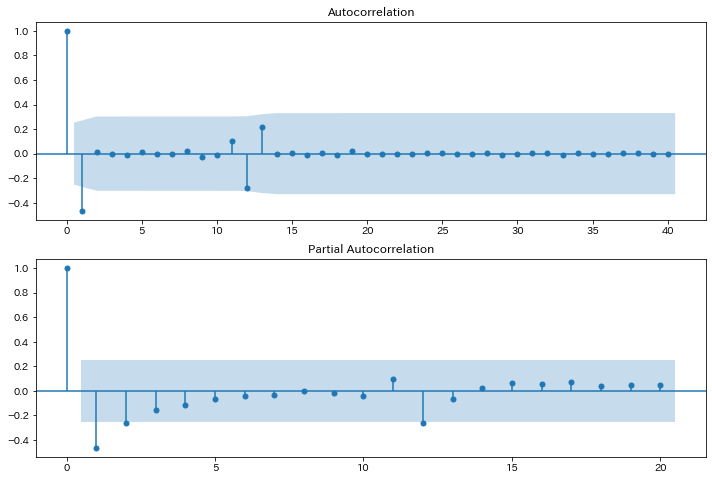

In [49]:
# 残差のチェック
residSARIMA = SARIMA_4_2_2_010.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=20, ax=ax2,method='ywm')

In [111]:
SARIMA_4_1_2_021 = sm.tsa.SARIMAX(train, order=(4,1,2), seasonal_order=(0,2,1,12)).fit(method='bfgs', maxiter=300)
print(SARIMA_4_1_2_021.summary())

         Current function value: 2.452821
         Iterations: 11
         Function evaluations: 91
         Gradient evaluations: 78
                                      SARIMAX Results                                       
Dep. Variable:                               worker   No. Observations:                   60
Model:             SARIMAX(4, 1, 2)x(0, 2, [1], 12)   Log Likelihood                -147.169
Date:                              Thu, 01 Jul 2021   AIC                            310.338
Time:                                      14:28:01   BIC                            322.781
Sample:                                  01-31-1967   HQIC                           314.634
                                       - 12-31-1971                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

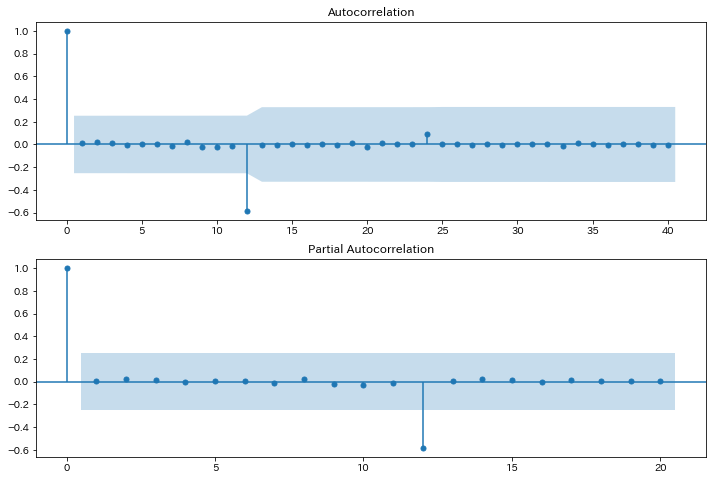

In [112]:
# 残差のチェック
residSARIMA = SARIMA_4_1_2_021.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=20, ax=ax2,method='ywm')

# SARIMA(4,1,2)(0,2,1,12)を選択した。

In [113]:
# 予測
pred =  SARIMA_4_1_2_021.predict('1972-01-01', '1979-12-31')
print(pred)

1972-01-31    1699.714306
1972-02-29    1678.087451
1972-03-31    1676.597442
1972-04-30    1669.601585
1972-05-31    1693.877152
                 ...     
1979-08-31    1818.333438
1979-09-30    1822.056626
1979-10-31    1650.213044
1979-11-30    1682.413172
1979-12-31    1638.109495
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [114]:
pred=pd.DataFrame(pred)
pred.head()

,predicted_mean
1972-01-31,1699.714306
1972-02-29,1678.087451
1972-03-31,1676.597442
1972-04-30,1669.601585
1972-05-31,1693.877152


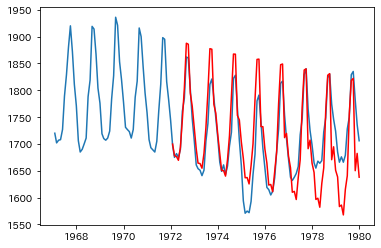

In [115]:
# 実データと予測結果の図示
plt.plot(df)
plt.plot(pred, "r")

### train期間の残差を二乗し、異常度とした上で閾値を設定する。

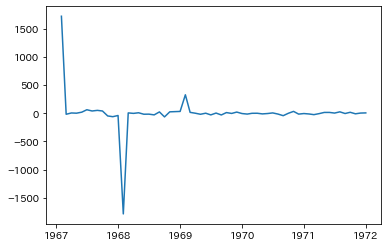

In [116]:
plt.plot(SARIMA_4_1_2_021.resid)

In [117]:
SARIMA_4_1_2_021.resid[0:13]

1967-01-31    1720.000000
1967-02-28     -17.854936
1967-03-31       4.938626
1967-04-30       1.034596
1967-05-31      18.966150
1967-06-30      62.030636
1967-07-31      39.989535
1967-08-31      51.008619
1967-09-30      40.006228
1967-10-31     -48.001398
1967-11-30     -60.990140
1967-12-31     -40.058686
1968-01-31   -1785.166211
Freq: M, dtype: float64

In [118]:
sarima_res = SARIMA_4_1_2_021.resid

In [119]:
a_i = sarima_res**2

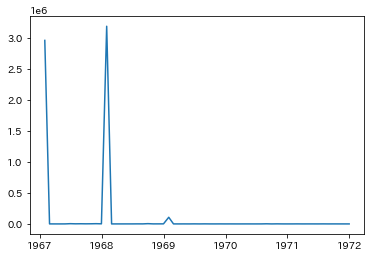

In [120]:
plt.plot(a_i)

In [122]:
a_i[0:30]

1967-01-31    2.958400e+06
1967-02-28    3.187988e+02
1967-03-31    2.439002e+01
1967-04-30    1.070389e+00
1967-05-31    3.597149e+02
1967-06-30    3.847800e+03
1967-07-31    1.599163e+03
1967-08-31    2.601879e+03
1967-09-30    1.600498e+03
1967-10-31    2.304134e+03
1967-11-30    3.719797e+03
1967-12-31    1.604698e+03
1968-01-31    3.186818e+06
1968-02-29    3.373616e+01
1968-03-31    5.833910e+00
1968-04-30    7.137018e+01
1968-05-31    3.042652e+02
1968-06-30    2.578727e+02
1968-07-31    8.389187e+02
1968-08-31    5.502982e+02
1968-09-30    4.220060e+03
1968-10-31    6.223356e+02
1968-11-30    8.147720e+02
1968-12-31    1.022747e+03
1969-01-31    1.070627e+05
1969-02-28    2.395893e+02
1969-03-31    5.105832e-02
1969-04-30    3.305180e+02
1969-05-31    4.606257e-01
1969-06-30    8.534600e+02
Freq: M, dtype: float64

In [126]:
np.count_nonzero(a_i>=4300)/np.count_nonzero(a_i)

0.05

##### 5 %水準で閾値（4300）を設定。
### SARIMAモデルを元にテストデータについて異常度を算出する。

In [127]:
test=df[df.index >= dt.datetime(1972,1,1)]

In [128]:
test.head()

,worker
1972-01-31,1697
1972-02-29,1675
1972-03-31,1682
1972-04-30,1675
1972-05-31,1690


In [129]:
a_i_hat=(pred['predicted_mean']-test['worker'])**2

In [130]:
a_i_hat

1972-01-31        7.367457
1972-02-29        9.532356
1972-03-31       29.187634
1972-04-30       29.142887
1972-05-31       15.032306
                  ...     
1979-08-31      113.775549
1979-09-30      167.530941
1979-10-31    17367.801899
1979-11-30     2871.548146
1979-12-31     4609.120676
Freq: M, Length: 96, dtype: float64

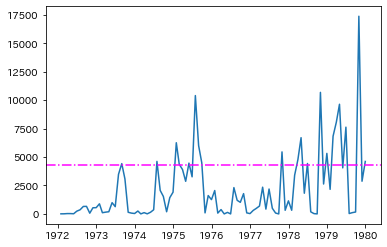

In [131]:
plt.plot(a_i_hat)
plt.axhline(4300, ls = "-.", color = "magenta")

In [132]:
np.count_nonzero(a_i_hat>=4300)/np.count_nonzero(a_i_hat)

0.20833333333333334

## テストデータの異常発生率は約21%。多い・・
### 訓練データとテストデータの異常度をくっつけて、全期間の異常度を見てみる。

In [133]:
a_i_sum = pd.DataFrame(pd.concat([a_i,a_i_hat]))
#a_i_sum = pd.DataFrame()

In [134]:
a_i_sum.head()

,0
1967-01-31,2.958400e+06
1967-02-28,3.187988e+02
1967-03-31,2.439002e+01
1967-04-30,1.070389e+00
1967-05-31,3.597149e+02


In [135]:
a_i_sum.shape

(156, 1)

In [137]:
np.count_nonzero(a_i_sum>=4300)/np.count_nonzero(a_i_sum)

0.14743589743589744

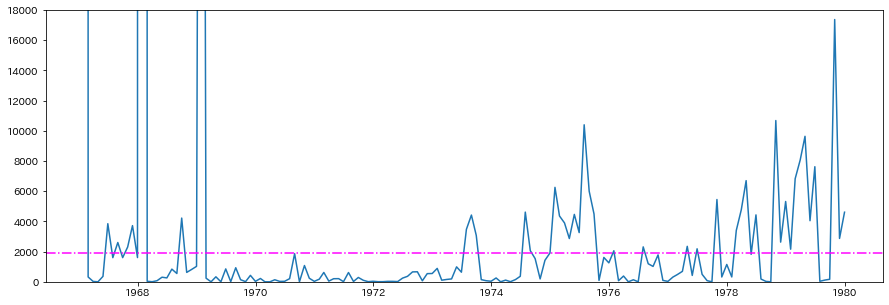

In [138]:
plt.figure(figsize=(15,5))
plt.plot(a_i_sum)
plt.ylim(0, 18000)
plt.axhline(1900, ls = "-.", color = "magenta")

Text(0, 0.5, '労働者数')

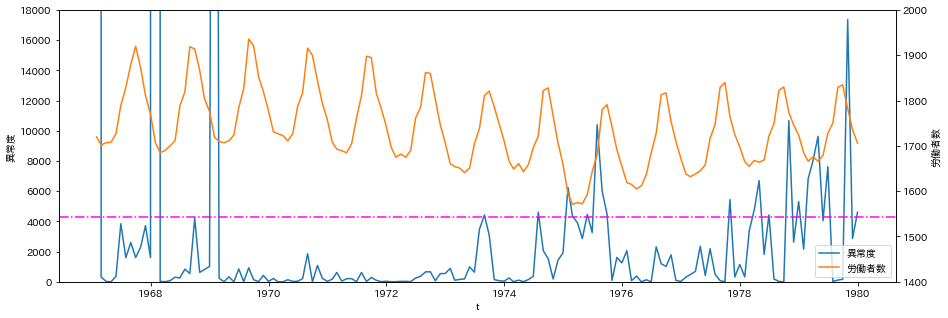

In [139]:
#https://qiita.com/supersaiakujin/items/e2ee4019adefce08e381
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)

t =df.index 
y1=a_i_sum[0]
y2=df['worker']

ln1=ax1.plot(t, y1,'C0',label='異常度')
ax1.set_ylim(0, 18000)

plt.axhline(4300, ls = "-.", color = "magenta")

ax2 = ax1.twinx()
ln2=ax2.plot(t,y2,'C1',label='労働者数')
ax2.set_ylim(1400, 2000)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')



ax1.set_xlabel('t')
ax1.set_ylabel('異常度')
#ax1.grid(True)
ax2.set_ylabel('労働者数')

### 異常度による異常検出は、1973〜1976年くらいまではそれなりにできているように思われる。
#### ・1973年６月 ニクソン政権の大豆輸出禁止政策
#### ・1974年〜1975年　景気後退期、スタグフレーション
### 1976年以降は上昇トレンドに切り替わっており、1967年〜1971年のデータを用いたSARIMAモデルの当てはまりの悪さが異常度の高さに繋がっているものと思われる。